<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L03/Robust_Optimization_example_LP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rsome
!pip install mosek
!rm mosek.lic
!git clone https://github.com/roberock/mosek_lic
!cp ./mosek_lic/mosek.lic .
!rm -r ./mosek_lic
!mkdir -p /root/mosek
!cp ./mosek.lic /root/mosek
#!pip install -i https://pypi.gurobi.com gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 48.7 MB/s eta 0:00:00
rm: cannot remove 'mosek.lic': No such file or directory
Cloning into 'mosek_lic'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [2]:
import rsome as rso
import numpy as np
from rsome import ro
from rsome import msk_solver as my_solver  #Import Mosek solver interface
#from rsome import grb_solver as my_solver  #Import Gurobi solver interface

In [3]:
# Parameters setup
n  = 150
i = np.arange(1, n+1)
c  = 0.15+ i*0.05/150
a = np.zeros(n)
b = 0.02

# Describing the uncertainty
maxDev = 0.05/450 * (2*i*n*(n+1))**0.5
uBarPlus = maxDev
uBarMinus = -maxDev

## **Solving Deterministic Model**

Consider the following linear programming problem:
\begin{align}
\max\limits_{x}\;\;&c^\top x \\
\text{subject to}\;\;& a^\top x \leq b\\
& 0 \leq x \leq 1.
\end{align}

In [4]:
#Create model
model = ro.Model('simpleExample_det')
x=model.dvar(n)
model.max(c@x)
model.st(a@x<=b)
model.st(x>=0)
model.st(x<=1)
model.solve(my_solver)
optobj_det = model.get()
xx_det   = x.get()
print('objective',optobj_det)
print('solution',xx_det)

Being solved by Mosek...
Solution status: Optimal
Running time: 0.0311s
objective 26.275
solution [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


## **Solving Raw Robust Counterpart**

Consider the following robust linear optimization problem:
\begin{align}
\max\limits_{x}\;\;&c^\top x \\
\text{subject to}\\ \;\;& (a + u)^\top x \leq b && \forall u \in \mathcal{U}\\
& 0 \leq x \leq 1,
\end{align}
where $$\mathcal{U}:=\{u\;|\;\bar{u}^- \leq u \leq \bar{u}^+\}.$$

In [5]:
#Create model
model = ro.Model('simpleExample_rawrobust')
x=model.dvar(n)

#Create uncertain vector
u = model.rvar(n)
#Create uncertainty set
USet = (u>=uBarMinus, u <= uBarPlus)
model.max(c@x)
#Robustify the constraint
model.st(((a+u)@x<=b).forall(USet))
model.st(x>=0)
model.st(x<=1)
model.solve(my_solver)

optobj_raw = model.get()
xx_raw   = x.get()

print('objective',optobj_raw)
print('solution',xx_raw)

Being solved by Mosek...
Solution status: Optimal
Running time: 0.0026s
objective 0.12713897073987465
solution [0.84571377 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0. 

## **Solving Reduced Robust Counterpart**

The robust counterpart can be reformulated as follows:

\begin{align}
\max\limits_{x,\lambda^+,\lambda^-}\;\;&c^\top x \\
\text{subject to}\\
\;\;& a ^\top x + (\bar{u}^+)^\top \lambda^+ - (\bar{u}^-)^\top \lambda^- \leq b, &&\\
& \lambda^+ -\lambda^- =x, \\
& \lambda^- \geq 0, \\
& \lambda^+ \geq 0,\\
& 0 \leq x \leq 1.
\end{align}

In [6]:
#Create model
model = ro.Model('simpleExample_redrobust')
x=model.dvar(n)
#Create auxiliary variables
lambdaPlus=model.dvar(n)
lambdaMinus=model.dvar(n)

model.max(c@x)
#Modify the deterministic constraint
model.st(a@x + uBarPlus@lambdaPlus - uBarMinus@lambdaMinus <=b)
#Add constraints from dual representation of worst-case optimization
model.st(lambdaPlus-lambdaMinus == x)
model.st(lambdaPlus>=0)
model.st(lambdaMinus>=0)

model.st(x>= 0)
model.st(x<=1)

model.solve(my_solver)

optobj_red = model.get()
xx_red   = x.get()

print('objective',optobj_red)
print('solution',xx_red)

Being solved by Mosek...
Solution status: Optimal
Running time: 0.0017s
objective 0.12713897073987465
solution [0.84571377 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0. 


# **Robust Portfolio Example**

In this example, the portfolio construction problem discussed in the previous sections is solved using a robust optimization approach introduced in the paper **Bertsimas and Sim (2004)**. The robust model is presented below:

### **Robust Optimization Model**
$$
\max_{\mathbf{x}} \min_{\mathbf{u} \in \mathcal{U}} \sum_{i=1}^n (p_i + \delta_i u_i)x_i
$$
subject to:
$$
\sum_{i=1}^n x_i = 1, \quad x_i \geq 0, \, \forall i = 1, 2, \dots, n,
$$
where the affine term $p_i + \delta_i u_i$ represents the random stock return, and the random variable $u_i$ is bounded within $[-1, 1]$.

 Thus, the stock return has an arbitrary distribution in the interval $[p_i - \delta_i, p_i + \delta_i]$.

 The uncertainty set $\mathcal{U}$ is given below:
$$
\mathcal{U} = \{\mathbf{u} : \|\mathbf{u}\|_\infty \leq 1, \|\mathbf{u}\|_1 \leq \Gamma\},
$$
where $\Gamma$ is the budget of uncertainty parameter.

### **Parameter Values**
The values of the budget of uncertainty and other parameters are presented as follows:

$$
\Gamma = 5, \quad p_i = 1.15 + \frac{i}{0.05 \times 150}, \quad \delta_i = 0.05 \sqrt{\frac{450}{i(n+1)}}, \, \forall i = 1, 2, \dots, n.
$$


Being solved by Mosek...
Solution status: Optimal
Running time: 0.0092s
objective 1.1568398884579691
solution investment fractions [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01409668 0.01377258 0.01346985 0.01318624
 0.01291982 0.01266893 0.0124321  0.01220808 0.01199575 0.01179413
 0.01160234 0.01141962 0.01124526 0.01107866 0.01091924 0.01076652
 0.01062003 0.01047936 0.01034414 0.01021402 0.01008869 0.00996786
 0.00985127 0.00973868 0.00962987 0.00952462 0.00942275 0.00932408
 0.00922844 0.00913569 0.00904568 0.00895828 0.00887337 0.00879083
 0.00871054 0.00863242 0.00855636 0.00848228 0.00841009 0.00833971
 0.00827107 0.00820409 0.00813872 0.00807489 0.00801253 0.0079516
 0.00789204 0.00783379 0.00777682 0.00772107 0.0076665  0.00761308
 0.00756075 0.00750949 0.00745926 0.00741003 0.00736175 0.00731441
 0.00726797 0.0072224  

<BarContainer object of 150 artists>

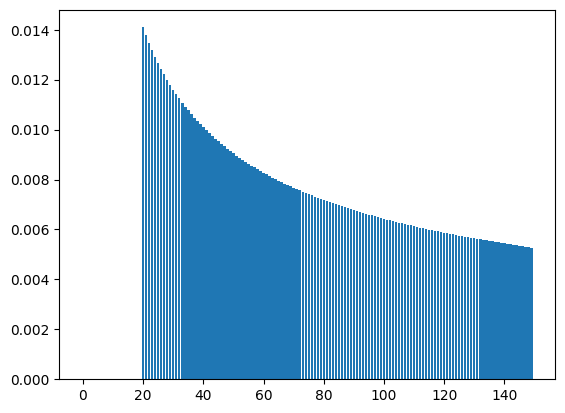

In [17]:
# example of max min
n = 150                                 # number of stocks
i = np.arange(1, n+1)                   # indices of stocks
p = 1.15 + i*0.05/150                   # mean returns
delta = 0.05/450 * (2*i*n*(n+1))**0.5   # deviations of returns
Gamma = 12                               # budget of uncertainty

model = ro.Model()
x = model.dvar(n)                       # fractions of investment
z = model.rvar(n)                       # random variables

model.maxmin((p + delta*z) @ x,         # the max-min objective
             rso.norm(z, np.infty) <=1, # uncertainty set constraints
             rso.norm(z, 1) <= Gamma)   # uncertainty set constraints
model.st(sum(x) == 1)                   # summation of x is one
model.st(x >= 0)                        # x is non-negative

model.solve(my_solver)                  # solve the model


print('objective',model.get())
print('solution investment fractions',x.get())

import matplotlib.pyplot as plt
plt.bar(range(n), x.get())